In [1]:
import numpy as np
import torch
import torch.nn as nn
from IPython.display import display, HTML
from transformers import DistilBertModel, DistilBertTokenizer, logging
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm_notebook
import spacy
from spacy import displacy
import seaborn as sns
import pandas as pd
import numpy as np
import collections
import glob
import pickle
import random
from scipy.stats import hmean
import re
from bs4 import BeautifulSoup
import requests
from sklearn.metrics.pairwise import cosine_similarity
nlp = spacy.load('en_core_web_trf')
logging.set_verbosity_error()

import sys
sys.path.insert(0, '../src/models/')
sys.path.insert(0, '../src/features/')

from build_features import similarity_matrix as vector_values
from predict_model import load_CUB_Bert, load_simBERT, loadBERT
from predict_model import SpanPredictor as classify

%matplotlib inline

# Preprocessing & Preparing

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Load models
Load the models for classification of descriptions

In [3]:
model = loadBERT("../models/", 'saved_weights_inf_FIXED_boot_beta80.pt')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

CPU Success


### CUB Annotations

In [4]:
# Open the text file
location = "../data/external/CUB_200_2011/CUB_200_2011/classes.txt"
with open(location) as f:
    lines = f.readlines()
    
# Open the text file
location = "../data/external/birdnames.txt"
with open(location) as f:
    lines_latin = f.readlines()
# Init regex
regex = r'\d+\s\d+\.'
# Clean the list
CUB = [re.sub(regex, '', line).rstrip().replace('_', ' ') for line in lines]

In [5]:
# Open the text file
location = "../data/external/CUB_200_2011/attributes.txt"
with open(location) as f:
    lines = f.readlines()
    
attribute_list = []

# Create a DF with attributes
for line in lines:
    line = line.strip()
    attributes = line.split()[1].split('::')
    part = attributes[0]
    adjective = attributes[1]
    attribute_list.append((part, adjective))
    
# Create DF        
df_attributes = pd.DataFrame(attribute_list, columns=['Part', 'Adj'])
# Reset the index
df_attributes.index = np.arange(1, len(df_attributes)+1)

In [6]:
# Open the text file
location = "../data/external/CUB_200_2011/CUB_200_2011/attributes/image_attribute_labels.txt"
with open(location) as f:
    lines = f.readlines()
# Open the text file
location = "../data/external/CUB_200_2011/CUB_200_2011/images.txt"
with open(location) as f:
    img_ids = f.readlines()
    
# Create DF will all present parts
CUB_dict = collections.defaultdict(list)
# Loop over lines
for line in tqdm_notebook(lines):
    data = line.split()
    # Skip non present
    if not int(data[2]):
        continue
    # Skip uncertain things
    if int(data[3]) < 4:
        continue
    # Otherwise append
    #print(CUB[int(img_ids[int(data[0])].split()[1][0:3]) - 1], data)
    CUB_dict[CUB[int(img_ids[int(data[0])-1].split()[1][0:3]) - 1]].append((df_attributes.loc[int(data[1]), ][0], df_attributes.loc[int(data[1]), ][1]))

  0%|          | 0/3677856 [00:00<?, ?it/s]

In [7]:
# Drop duplicates
# Images are annotated per image and not bird
# Resulting in multiple sightings per bird
for bird in CUB_dict.keys():
    CUB_dict[bird] = list(set(CUB_dict[bird]))

### Extract common birds

In [8]:
# Open the text file
location = "../data/external/CUB_200_2011/CUB_200_2011/classes.txt"
with open(location) as f:
    lines = f.readlines()

# Init regex
regex = r'\d+\s\d+\.'
# Clean the list
CUB = [re.sub(regex, '', line).rstrip().replace('_', ' ') for line in lines]
# Read the BOWO list to compare names
BOWO_folder_list = glob.glob('../data/raw/BOW/*')
# Clean the lists
BOW_all = [bird[16:] for bird in BOWO_folder_list]
# Intersect common names
common_birds = list(set(CUB) & set(BOW_all))
# Uncommon birds
Uncommon_birds = list(set(CUB) - set(common_birds))

In [9]:
text_list = []

for bird in common_birds:
    text_list.append((bird, bird))

In [10]:
remaining = [
    'Cape Starling',
    'Eurasian Tree Sparrow',
    'American White Pelican',
    'Common Nighthawk',
    "Forster's Tern",
    'Greater Roadrunner',
    'Black-and-white Warbler',
    'Northern Cardinal',
    'American Three-toed Woodpecker',
    'Yellow-rumped Warbler',
    'White-throated Kingfisher',
    'Great Gray Shrike',
    "Nelson's Sparrow",
    'Gray-crowned Rosy-Finch',
    "LeConte's Sparrow",
    'Eastern Whip-poor-will',
    'Eastern Phoebe',
    'Mexican Violetear',
    "Chuck-will's-widow",
    'Great Frigatebird',
    'Florida Scrub-Jay',
    'Arctic Tern',
    'Northern Mockingbird',
    'Western Wood-Pewee',
]

In [11]:
idx = 0
for CUB_bird in Uncommon_birds:
    # Rewrite bird
    parts = CUB_bird.split()
    if len(parts) == 2:
        bird = f"{parts[0]}'s {parts[1]}"
    elif len(parts) == 3:
        bird = f'{parts[0]}-{parts[1]} {parts[2]}'
    elif len(parts) == 4:
        bird = f'{parts[0]}-{parts[1]} {parts[2]} {parts[3]}'
    if bird in BOW_all:
        #print(CUB_bird,'===', bird)
        common_birds.append(bird)
        text_list.append((CUB_bird, bird))
        #print('yes')
    else:
        common_birds.append(remaining[idx])
        text_list.append((CUB_bird, remaining[idx]))
        #print(CUB_bird, '===', remaining[idx])
        idx += 1
    # Reset bird:
    bird = 'XIXIXIX'

In [12]:
# retoken CUB
CUB_dict_new = collections.defaultdict(list)

for (CUB, BOW) in text_list:
    CUB_dict_new[BOW] = CUB_dict[CUB]

In [13]:
assert len(common_birds) == 200

In [14]:
text_list

[('Pine Grosbeak', 'Pine Grosbeak'),
 ('American Pipit', 'American Pipit'),
 ('Summer Tanager', 'Summer Tanager'),
 ('Savannah Sparrow', 'Savannah Sparrow'),
 ('Common Yellowthroat', 'Common Yellowthroat'),
 ('Acadian Flycatcher', 'Acadian Flycatcher'),
 ('Northern Fulmar', 'Northern Fulmar'),
 ('Pileated Woodpecker', 'Pileated Woodpecker'),
 ('Hooded Merganser', 'Hooded Merganser'),
 ('Tree Swallow', 'Tree Swallow'),
 ('Tennessee Warbler', 'Tennessee Warbler'),
 ('Western Gull', 'Western Gull'),
 ('Rock Wren', 'Rock Wren'),
 ('Kentucky Warbler', 'Kentucky Warbler'),
 ('Herring Gull', 'Herring Gull'),
 ('Vermilion Flycatcher', 'Vermilion Flycatcher'),
 ('Great Crested Flycatcher', 'Great Crested Flycatcher'),
 ('Song Sparrow', 'Song Sparrow'),
 ('Ovenbird', 'Ovenbird'),
 ('Winter Wren', 'Winter Wren'),
 ('Hooded Warbler', 'Hooded Warbler'),
 ('Eared Grebe', 'Eared Grebe'),
 ('Spotted Catbird', 'Spotted Catbird'),
 ('Brown Pelican', 'Brown Pelican'),
 ('Chipping Sparrow', 'Chipping Spar

### Get bird descriptions

In [13]:
birds_single_html = [Species[16:] for Species in BOWO_folder_list if len(glob.glob(Species + '/*')) == 1]
birds_multiple_html = [Species[16:] for Species in BOWO_folder_list if len(glob.glob(Species + '/*')) != 1]

In [ ]:
# Insersect
common_birds_single_html = list(set(common_birds) - set(birds_multiple_html))

birds_single_html = list(set(birds_single_html) - set(common_birds_single_html))

# Sample from single list so to get 2000 birds total
additional_birds = random.sample(birds_single_html, int(200/0.1 - (len(birds_multiple_html) + len(common_birds_single_html))))
# Construct final list
bird_list = birds_multiple_html + common_birds_single_html + additional_birds
# Check
assert len(bird_list) == 2000

In [ ]:
# Init dict for storage
#birds_dict = collections.defaultdict(list)
# Reset to large (OOV does not work with transformers)
nlp = spacy.load('en_core_web_lg')

for bird_loc in tqdm_notebook(BOWO_folder_list[0:]):
    # Get the name
    BIRD = bird_loc[16:]
    if BIRD not in bird_list:
        #print(BIRD)
        continue
    # Check the amount of account
    HTMLs = glob.glob(bird_loc + '/*')
    #print(HTMLs)
    #if len(HTMLs) == 1:
    #    HTMLs = [HTMLs]
    for HTML in HTMLs:    
        # Open the HTML
        with open(HTML) as f:
            # Structure it
            soup = BeautifulSoup(f, 'html.parser')
            # Get all spans
            spans = [span for span in soup.find_all('p') 
                     if not 'fig' in span.text]
            for span in spans:
                # Get the text
                span = span.text
                # Clean ()
                text = re.sub(r'\((.+)\)', '', span)
                text = re.sub(r'\(.*?\)', '', text, flags=re.DOTALL)
                # Replace ; with . to help the sentecizer
                text = text.replace(';', '.')
                # NLP
                doc = nlp(text)
                for sent in doc.sents:    
                    # Skip short sents
                    if len(sent) <= 4:
                        continue
                    # Check amount of non-english
                    non_eng = [token.is_oov for token in sent].count(True)
                    # Skip if the ratio is above .2
                    if non_eng > 0 and non_eng / len(sent) > .2:
                        continue
                    # Also skip if the non-eng is large
                    if non_eng > 8:
                        continue
                    # Check classification
                    if classify(sent.text, model=model):
                        birds_dict[BIRD].append(sent.text)


In [ ]:
with open('../data/description/03_DESC_0000000-0002000_BIRDS.pkl', 'wb') as f:
    pickle.dump(birds_dict, f)

# Additional Random Data

In [ ]:
with open('../data/description/04_TRAIN_0000000-0002000_BIRDS.pkl', 'wb') as f:
    pickle.dump(train_dict, f)

# Attribution Techniques

In [198]:
data = pickle.load(open('../data/description/04_TRAIN_0000000-0002000_BIRDS.pkl', 'rb'))
model = load_CUB_Bert("../models/", 'saved_weights_CUB_BIRDS_2000.pt')

Local Success


### Helper functions

In [199]:
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

# Modify the prediction output and define a custom forward
def predict(inputs, attentions):
    return model(input_ids=inputs, attention_mask=attentions)[0]

def custom_forward(inputs, attentions):
    preds = predict(inputs, attentions)
    return torch.exp(preds)

# Tokenize functions
def construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id):

    text_ids = tokenizer.encode(text, add_special_tokens=False)
    # construct input token ids
    input_ids = [cls_token_id] + text_ids + [sep_token_id]
    # construct reference token ids 
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(text_ids)

def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)# * -1
    return token_type_ids, ref_token_type_ids

def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids
    
def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

# Summarize and vis functions
def summarize_attributions_ig(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

def summarize_attributions_occ(attributions):
    return attributions.sum(axis=0)

def token_to_words(attribution, tokens):
    
    words = []
    attributes = []

    for attribute, word in zip(attribution, tokens):

        attribute = attribute.cpu().detach().numpy()
        if word == '[CLS]' or word == '[SEP]':
            words.append(word)
            attributes.append([attribute])
        elif not word.startswith('##'):
            words.append(word)
            attributes.append([attribute])
        elif word.startswith('##'):
            words[-1] += word.strip('##')
            attributes[-1] = np.append(attributes[-1], attribute)

    attribution = [np.sum(mean) for mean in attributes]
    return attribution, words

def colorize(attribution, tokens):
    
    template = """  
    <mark class="entity" style=" background: {}; padding: 0.4em 0.0em; margin: 0.0em; line-height: 2; 
    border-radius: 0.0em; ">{}<span style=" font-size: 0.8em;  font-weight: bold;  line-height: 1; 
    border-radius: 0.0em; text-align-last:center; vertical-align: middle; margin-left: 0rem; "></span></mark>
    """

    colored_string = ''
    normalized_and_mapped = matplotlib.cm.ScalarMappable(cmap=matplotlib.cm.Greens).to_rgba(attribution)
    for idx, (word, color) in enumerate(zip(tokens, normalized_and_mapped)):
        
        word = word + ' '
        color = matplotlib.colors.rgb2hex(color[:3])
        if word.strip() == '[CLS]' or word.strip() == '[SEP]': 
            color = '#ffffff'
        #print(color)
        colored_string += template.format(color, word)

    return colored_string

def explain(word):
    
    data = collections.defaultdict(list)
       
    # tokenize
    input_ids, ref_input_ids, sep_id = construct_input_ref_pair(word, ref_token_id, sep_token_id, cls_token_id)
    token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
    position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
    attention_mask = construct_attention_mask(input_ids)
    indices = input_ids[0].type(torch.LongTensor)
    all_tokens = tokenizer.convert_ids_to_tokens(indices)
    
    #### Layer IG 20 steps
    attribution_ig = lig.attribute(inputs=(input_ids, attention_mask),
                                    baselines=(ref_input_ids, attention_mask),
                                    n_steps=20,
                                    internal_batch_size=1,
                                    return_convergence_delta=False)
    attributions_ig_sum = summarize_attributions_ig(attribution_ig)
    attributions_ig_words, words = token_to_words(attributions_ig_sum, all_tokens)
    data['Words'] = words
    data['IG_20'] = attributions_ig_words
    ####
    
    #### Layer IG 100 steps
    attribution_ig_100 = lig.attribute(inputs=(input_ids, attention_mask),
                                    baselines=(ref_input_ids, attention_mask),
                                    n_steps=50,
                                    internal_batch_size=1,
                                    return_convergence_delta=False)
    attribution_ig_100_sum = summarize_attributions_ig(attribution_ig_100)
    attributions_ig_100_words, _ = token_to_words(attribution_ig_100_sum, all_tokens)
    #print(attribution_ig_100_sum)
    data['IG_50'] = attributions_ig_100_words
    ####
    
    ### Occlusion maps 
    attribution_occ = occ.attribute(inputs=(input_ids, attention_mask),
                                sliding_window_shapes=(tuple([1,]), tuple([1,])), 
                                baselines=(ref_input_ids, attention_mask),)
    attributions_occ_sum = summarize_attributions_occ(attribution_occ[0])
    attributions_occ_words, _ = token_to_words(attributions_occ_sum, all_tokens)
    data['Occ_1-1'] = attributions_occ_words
    #### Occlusion maps (3, 2)
    attribution_occ2 = occ.attribute(inputs=(input_ids, attention_mask),
                                sliding_window_shapes=(tuple([3,]), tuple([3,])), 
                                strides=(2, 2), 
                                baselines=(ref_input_ids, attention_mask),)
    attribution_occ2_sum = summarize_attributions_occ(attribution_occ2[0])
    attributions_occ2_words, _ = token_to_words(attribution_occ2_sum, all_tokens)
    data['Occ_3-2'] = attributions_occ2_words
    ####
    
    #### Shapley Value Sampling
    attribution_SVS = SVS.attribute(inputs=(input_ids, attention_mask),
                                baselines=(ref_input_ids, attention_mask),
                                   n_samples=5)
    attributions_SVS_sum = attribution_SVS[0][0]
    attributions_SVS_words, _ = token_to_words(attributions_SVS_sum, all_tokens)
    data['SVS'] = attributions_SVS_words
    ####
    
    ### Layer Activation
    attribution_la = la.attribute(inputs=(input_ids, attention_mask),)
    attributions_la_sum = summarize_attributions_ig(attribution_la)
    attributions_la_words, _ = token_to_words(attributions_la_sum, all_tokens)
    data['LA'] = attributions_la_words
    
    attribution_lgxa = lgxa.attribute(inputs=input_ids,
                                 additional_forward_args=attention_mask,
                                 attribute_to_layer_input=False)
    attributions_lgxa_sum = summarize_attributions_ig(attribution_lgxa)
    attributions_lgxa_words, words = token_to_words(attributions_lgxa_sum, all_tokens)
    data['LGXA'] = attributions_lgxa_words
    
    return data

### Explanatory Methods

In [200]:
from captum.attr import LayerActivation, LayerIntegratedGradients 
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer
from captum.attr import Occlusion, FeatureAblation, ShapleyValueSampling
from captum.attr import LayerFeatureAblation
from captum.attr import LayerGradientXActivation

In [201]:
lig     = LayerIntegratedGradients(custom_forward, model.bert.embeddings)
occ     = Occlusion(custom_forward)
ablator = FeatureAblation(custom_forward)
lfa     = LayerFeatureAblation(custom_forward, model.bert.embeddings)
SVS     = ShapleyValueSampling(custom_forward)
la      = LayerActivation(custom_forward, model.bert.embeddings)
lgxa    = LayerGradientXActivation(custom_forward, model.bert.embeddings)

In [202]:
# Single Example
string = 'Orange legs with long nails.'
test_example = explain(string)

In [203]:
# Skip first (contains tokens)
for attribution in list(test_example.keys())[1:]:
    words = test_example['Words']
    string = colorize(test_example[attribution], words)
    print(attribution)
    display(HTML(string))

IG_20


IG_50


Occ_1-1


Occ_3-2


SVS


LA


LGXA


In [204]:
common_birds[0:2]

['House Sparrow', 'Blue Jay']

In [205]:
attribution = collections.defaultdict(list)
idx = 0

# Loop over common birds
#for bird in tqdm_notebook(list(data.keys())[0:2], desc='Bird'):
for bird in tqdm_notebook(common_birds[0:2], desc='Bird'):
    # Get descriptions
    text_list = [text for text in data[bird]]
    # Get attribution values
    for text in tqdm_notebook(text_list[0:], desc='Text', leave=False):
        d = explain(text)
        d['Sentence'] = len(d['Words']) * [idx]
        d['Bird'] = len(d['Words']) * [bird]
        for key in d.keys():
            attribution[key] += d[key]
        
        idx += 1

Bird:   0%|          | 0/2 [00:00<?, ?it/s]

Text:   0%|          | 0/104 [00:00<?, ?it/s]

Text:   0%|          | 0/118 [00:00<?, ?it/s]

### Get Bird Glossary

In [216]:
# URL
URL = 'https://en.wikipedia.org/wiki/Glossary_of_bird_terms'
# Get the page
page = requests.get(URL, timeout=5)
soup = BeautifulSoup(page.content, "lxml", from_encoding="iso-8859-1")   
# Find embedded glossary
glossaries = soup.find_all('dt', {'class': 'glossary'})
parts = [part.text.lower().strip() for part in glossaries]
# Get additional anchors ("also know as...")
glossaries_other = soup.find_all('span', {'class': 'anchor'})
parts_other = [part['id'].lower().strip() for part in glossaries_other]
# Append and drop duplicates
parts = list(set((parts + parts_other)))
# Replace underscore with space
parts = [part.replace('_', ' ') for part in parts]

In [217]:
# Drop into a df
df_attribution = pd.DataFrame.from_dict(attribution)

data_random = []
# Extract highest attributions
for idx in tqdm_notebook(df_attribution['Sentence'].unique()):
#for idx in range(50, 51):
    #doc = nlp(text_list[idx])
    doc = nlp(' '.join(df_attribution[df_attribution['Sentence'] == idx]['Words']))
    if len(doc) <= 2:
        continue
    # Check single
    words = [chunk.root.lemma_.lower() for chunk in doc.noun_chunks] 
    # Check multiple
    words += [chunk.root.text.lower() for chunk in doc.noun_chunks]
    # Drop duplicate
    words = list(set(words))
    #print(words)
    #print(words)
    traits =  set(words) & set(parts)
    #print(traits)
    if traits:
        # Yield the traits
        trait_list = list(traits)
        #print(trait_list)
        for trait in trait_list:
            for column in df_attribution.columns[1:-2]:
                #print(column)
                index = df_attribution[df_attribution['Sentence'] == idx][column].sort_values(ascending=False)
                data_random.append((idx, column, df_attribution.iloc[index.index[0]].Words, trait, df_attribution.iloc[index.index[0]].Bird))

  0%|          | 0/222 [00:00<?, ?it/s]

In [219]:
description_CUB_dict = []
# Rewrite the sentence
for bird in tqdm_notebook(df_attribution.Bird.unique()): 
    for (part, adjective) in CUB_dict[bird]:
        part = part[4:].replace('_', ' ')

        description_CUB_dict.append((part, adjective, bird))

  0%|          | 0/2 [00:00<?, ?it/s]

In [220]:
# create DataFrame using data
df_random = pd.DataFrame(data_random, columns =['Sentence', 'Attribution', 'Adjective', 'Part', 'Bird'])
df_cub = pd.DataFrame(description_CUB_dict, columns =['Part', 'Adjective', 'Bird'])

# Create trait
df_random['Trait'] = df_random['Part'] + ' ' + df_random['Adjective']
df_cub['Trait'] = df_cub['Part'] + ' ' + df_cub['Adjective']

# Create similarity column
#df_random['Similarity'] = np.nan

In [223]:
# Init SIMmodel
SIMmodel = load_simBERT()

In [224]:
comparison_list = []

for bird in tqdm_notebook(df_random['Bird'].unique(), desc='bird'):
    for part in tqdm_notebook(df_random['Part'].unique(), desc='part', leave=False):
        # Get CUB DATA
        CUB_subset = list(df_cub[
            (df_cub['Trait'].str.startswith(part)) & 
            (df_cub['Bird'] == bird)]
                         ['Trait'])
        if CUB_subset:
            # Get the vector values
            vectors_CUB = vector_values(CUB_subset, model=SIMmodel)
            # Get the attribution
            for attribution in df_random['Attribution'].unique():
                #print(bird, attribution, part)
                RANDOM_subset = list(df_random[
                    (df_random['Bird'] == bird) & 
                    (df_random['Part'] == part) &
                    (df_random['Attribution'] == attribution)]
                                    ['Trait'])
                # Some part do not exists with birds
                if RANDOM_subset:
                    # Get vectors
                    vectors_RANDOM = vector_values(RANDOM_subset, model=SIMmodel)
                    # Compute similarity
                    matrix = cosine_similarity(vectors_CUB, vectors_RANDOM)
                    # Append    
                    #comparison_list.append((bird, part, attribution, matrix))
                    #comparison_list.append((bird, part, attribution, matrix.mean(axis=0)))
                    comparison_list.append((bird, part, attribution, matrix.max()))
                    #comparison_list.append((bird, part, attribution, hmean(matrix.max(axis=1))))
                    # Clear memory 
                    del vectors_RANDOM
            # Clear memory    
            del vectors_CUB


bird:   0%|          | 0/2 [00:00<?, ?it/s]

part:   0%|          | 0/65 [00:00<?, ?it/s]

part:   0%|          | 0/65 [00:00<?, ?it/s]

In [231]:
comparison_list

[('House Sparrow', 'throat', 'IG_20', 0.9431951),
 ('House Sparrow', 'throat', 'IG_50', 0.9431951),
 ('House Sparrow', 'throat', 'Occ_1-1', 0.9219235),
 ('House Sparrow', 'throat', 'Occ_3-2', 0.96153057),
 ('House Sparrow', 'throat', 'SVS', 0.9431951),
 ('House Sparrow', 'throat', 'LA', 0.7584883),
 ('House Sparrow', 'throat', 'LGXA', 0.9431951),
 ('House Sparrow', 'tail', 'IG_20', 0.90224314),
 ('House Sparrow', 'tail', 'IG_50', 0.90224314),
 ('House Sparrow', 'tail', 'Occ_1-1', 0.87441754),
 ('House Sparrow', 'tail', 'Occ_3-2', 0.86940515),
 ('House Sparrow', 'tail', 'SVS', 0.8820437),
 ('House Sparrow', 'tail', 'LA', 0.8820437),
 ('House Sparrow', 'tail', 'LGXA', 0.87441754),
 ('House Sparrow', 'wing', 'IG_20', 0.89565945),
 ('House Sparrow', 'wing', 'IG_50', 0.8969706),
 ('House Sparrow', 'wing', 'Occ_1-1', 0.90647113),
 ('House Sparrow', 'wing', 'Occ_3-2', 0.9404692),
 ('House Sparrow', 'wing', 'SVS', 0.90647113),
 ('House Sparrow', 'wing', 'LA', 0.8152548),
 ('House Sparrow', 'wi

In [ ]:
len(comparison_list)

In [ ]:
'''
####
#### PER SENTENCE
####
attribution_dict = collections.defaultdict(list)

# Per sentence to save memory
for idx in tqdm_notebook(df_random['Sentence'].unique()):
#for idx in range(0, 5):
    df_subset = df_random[(df_random['Sentence'] == idx)]
    parts = df_subset['Part'].unique()
    bird  = df_subset['Bird'].iloc[0]
    
    # Compute Vector values
    #vv_random = vector_values(list(df_subset['Traits']))
    for part in parts:
        random_text_list = list(df_subset[df_subset['Part'] == part]['Trait'])
        CUB_text_list =  list(df_cub[(df_cub['Trait'].str.startswith(part)) & (df_cub['Bird'] == bird)]['Trait'])
    
        #print(len(random_text_list), len(CUB_text_list))
    
        # Skip empty lists 
        if not CUB_text_list:
            continue
        # Compute Vector values
        vv_random = vector_values(random_text_list, model=SIMmodel)
        vv_cub    = vector_values(CUB_text_list, model=SIMmodel)

        # Get Matrix
        matrix = cosine_similarity(vv_random, vv_cub)
        # Clear memory
        del vv_random
        del vv_cub

        for word, attribution, row in zip(df_subset[df_subset['Part'] == part]['Trait'], df_subset[df_subset['Part'] == part]['Attribution'], matrix):
            attribution_dict[attribution].append((word, list(row)))
            
            #attribution_dict[attribution].append(list(row)) 
            #attribution_dict['Trait'].append(word) 
        #df_random.loc[df_subset.index, 'Similarity'] = np.mean(matrix, axis=1)
'''

### Similarity Example

In [ ]:
sents = [
    'The European robin\n has a orange plumage.',
    'Black bill,\n plumage orange.',
    'The bear is large and\n the claws are sharp.',
    'Bill black;\n plumage orange.',
    'The bill is black and\n the plumage is orange.',
    'The bear is large, and\n the claws are sharp.'
]

vv1 = vector_values(sents, model=SIMmodel)
vv2 = vector_values(sents, model=SIMmodel)

matrix = cosine_similarity(vv1, vv2)

mask = np.zeros_like(matrix)
mask[np.triu_indices_from(mask)] = True

# Delete empty rows and columns
matrix = np.delete(matrix, (0), axis=0)
mask = np.delete(mask, (0), axis=0)
matrix = np.delete(matrix, (-1), axis=1)
mask = np.delete(mask, (-1), axis=1)

df = pd.DataFrame(matrix)
df.index = sents[1:]
df.columns = sents[:-1]

In [ ]:
sents1 = [
    #'Bill color orange',
    'Bill shape cone',
    'Bill color yellow',
    'Bill pattern freckled',
    'Bill all-purpose',
    'bill length \nshorter_than_head'
]

sents2 = [
    'Bill [SEP]',
    'Bill yellow',
    'Bill orange',
    'Bill length 5 cm',
    'bill cone-shaped'
    #'Bill shape cone'
]

vv1 = vector_values(sents1, model=SIMmodel)
vv2 = vector_values(sents2, model=SIMmodel)

matrix = cosine_similarity(vv1, vv2)
df = pd.DataFrame(matrix)
df.index = sents1
df.columns = sents2

In [ ]:
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 7))
    ax = sns.heatmap(df, 
                     square=True,
                     annot=True,
                     cbar=False,
                     #cmap='Spectral_r', 
                     cmap=cmap,
                     linewidths=.5,)
    
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right", fontsize=11)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha="right", fontsize=11)


#f.suptitle('Similarity Matrix', fontsize=13)
f.savefig('similarity_matrix.pdf', format='pdf', dpi=1200, bbox_inches='tight')

### Average Similarity

In [ ]:
attribution_dict_nowords = collections.defaultdict(list)
#attribution_mean_dict_nowords = collections.defaultdict(list)
for key in attribution_dict.keys():
    for (word, items) in attribution_dict[key]:
        #attribution_mean_dict_nowords[key].append(np.mean(items))
        for item in items:
            attribution_dict_nowords[key].append(item)
    

In [225]:
df_attribution = pd.DataFrame(comparison_list,
                              columns=['Bird', 'Part', 'Attribution', 'Value'])

In [226]:
df_attribution.groupby(['Attribution'])['Value'].apply(hmean)

Attribution
IG_20      0.873894
IG_50      0.856254
LA         0.802257
LGXA       0.835784
Occ_1-1    0.858605
Occ_3-2    0.854242
SVS        0.846534
Name: Value, dtype: float64

In [227]:
df_attribution_melt = pd.melt(df_attribution, id_vars=['Attribution'], value_vars=['Value'])

In [228]:
df_attribution_melt

,Attribution,variable,value
0,IG_20,Value,0.943195
1,IG_50,Value,0.943195
2,Occ_1-1,Value,0.921924
3,Occ_3-2,Value,0.961531
4,SVS,Value,0.943195
...,...,...,...
156,Occ_1-1,Value,0.819452
157,Occ_3-2,Value,0.791472
158,SVS,Value,0.791472
159,LA,Value,0.763595


<AxesSubplot:xlabel='value', ylabel='Count'>

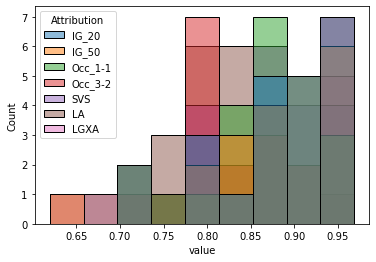

In [229]:
sns.histplot(data=df_attribution_melt, x="value", hue="Attribution")

[Text(0, 0, 'Integrated Gradients \n (20 Steps)'),
 Text(1, 0, 'Integrated Gradients \n (50 Steps)'),
 Text(2, 0, 'Occlusion \n (Window 1 and Stride 1)'),
 Text(3, 0, 'Occlusion \n (Window 3 and Stride 2)'),
 Text(4, 0, 'Sharpley Value Sampling'),
 Text(5, 0, 'Layer Attention'),
 Text(6, 0, 'Layer Gradient x Activation')]

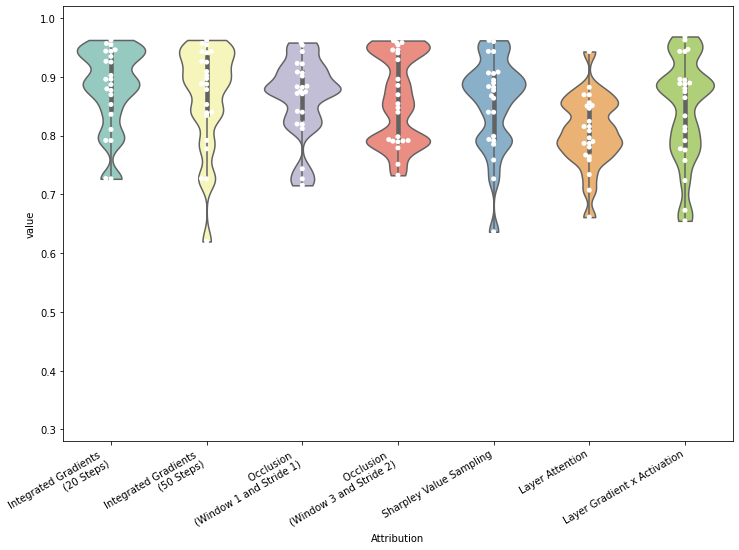

In [230]:
labels = ['Integrated Gradients \n (20 Steps)',
          'Integrated Gradients \n (50 Steps)',
          'Occlusion \n (Window 1 and Stride 1)',
          'Occlusion \n (Window 3 and Stride 2)',
          'Sharpley Value Sampling',
          'Layer Attention',
           'Layer Gradient x Activation']

fig, ax = plt.subplots(figsize=(12, 8))
#seaborn.violinplot(ax=ax, data=df, **violin_options)
ax = sns.violinplot(ax=ax, x="Attribution", y="value",  data=df_attribution_melt, bw=.2,
                   cut=0, palette="Set3", inner="box")

ax = sns.swarmplot(ax=ax, x="Attribution", y="value",  data=df_attribution_melt,
                   color="white", edgecolor="black")


ax.set_ylim(bottom=0.28, top=1.02)
ax.set_yticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax.set_xticklabels(labels, rotation=30, ha="right")

### STATS

In [ ]:
import scipy.stats as stats
import pylab 

In [ ]:
stats.probplot(df_att_arr['SVS'], dist="norm", plot=pylab)
pylab.show()

In [ ]:
fvalue, pvalue = stats.f_oneway(df_att_arr['IG_20'], 
                                df_att_arr['IG_50'], 
                                df_att_arr['Occ_1-1'], 
                                df_att_arr['Occ_3-2'],
                                df_att_arr['SVS'],
                                df_att_arr['LA'],
                                df_att_arr['LGXA'])

print(fvalue, pvalue)

In [ ]:
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [ ]:

# DataFrame.
Results = pairwise_tukeyhsd(endog=df_att_arr_melt['value'],
                           groups=df_att_arr_melt['variable'],
                           alpha=0.05)

print(Results)